# Running Molecular Dynamics Simulations in OpenMM

## Overview
**Molecular Dynamics Simulation**: simulation of molecules through time via calculations of forces on atoms and their positions based on those forces. The output is a trajectory.

## Steps for running a simulation
1. **Initialization** -- setting up imports, variables, and other system parameters to prepare for the simulation
2. **Minimization** -- calculating the energies of moving molecules slightly to obtain a local "minimum" in energy and eliminate “bad” interatomic contacts
3. **Equilibration** -- a brief MD simulation that prepares our system to our target temperature and desired equilibrium values
4. **Production** -- run the equilibration
5. **Analysis** -- after you have collected your data from the production run, you must analyze the trajectory to draw conclusions

## Our First Simulations
We will now use [OpenMM](https://openmm.org/documentation) to do a molecular dynamics simulation of the ethane and butane molecules we prepared. It’s important to note at this point that molecular dynamics simulations can be performed using a number of softwares. However, we will be running a simulation with a program called OpenMM. OpenMM has the advantage of being scriptable with Python.

---

### Initialization
Once you have OpenMM, we can use it to simulate our molecules. Start in your notebook with imports. Here are the python libraries you will need to run simulations with OpenMM.

In [1]:
import openmm as mm
from openmm import app, unit

First, we need to read in our structure and our force field. We have to tell the simulation our initial coordinates and the force field we will use. To do this, we use the PDB file we have and the force field file we prepared.

In [2]:
pdb = app.PDBFile('data/ethane.pdb')
forcefield = app.ForceField('data/ethane.gaff2.xml')

#### QUESTION
What are we doing with these two commands above?
*(Hint: let's check out some [documentation](http://docs.openmm.org/latest/userguide/application/02_running_sims.html))*

#### RESPONSE
1. `PDBFile` is to create a `PDBFile` object and call it `pdb` by reading the `ethane.pdb` file in the `/data` directory.
2. `ForceField` is to create a `ForceField` object and call it `forcefield` by reading the `ethane.gaff2.xml` file in the `/data` directory.

#### QUESTION
What lies in the contents of the XML file being read in `forcefield`?

#### RESPONSE
It includes the definition of the force field that specific to ethane. By looking into it, there are codes that define the name, mass, and types of the atoms; and lengthes and angles of the bonds.

Next, we set up the system for our MD simulation. With the following command, we use the `pdb` variable to create a system. The other arguments to the function say that we are not using a cut-off and that we want to constrain bonds with hydrogens (this allows us to use a larger timestep).

In [3]:
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

Our simulation will be in vacuum at a temperature of 298.15 K. The Langevin integrator is what is called a stochastic integrator. This means that it mimics jostling of air or solvent through random forces. We are using a 5.0 picosecond coupling constant, which is something which controls how often the integrator adds jostling motions.

In [4]:
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

#### QUESTION
What is the `integrator` applying to our simulation?

#### RESPONSE
The intergrator is specified as `LangevinIntergrator` type of dynamics. Langevin dynamics: the simulation temperature (298.15 K), the friction coefficient (5 ps-1), and the step size (2 fs).

Finally, we initialize the simulation by adding all of the pieces we have prepared:

In [6]:
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform) # ENTER THE THREE PIECES OF OUR SIMULATION HERE (hmm... I wonder where I can find this)
simulation.context.setPositions(pdb.positions)

---

### Minimization
Now, we start calculating energies. First we do an energy minimization. We start in this code block by printing the energy before minimization, doing 100 steps of an energy minimization, then printing the new energy. You should see that the energy decreases:

In [7]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 4.467818271065182 kJ/mol
Potential energy after minimization is 4.389967724953268 kJ/mol


You can’t see it from this code, but the atom positions have changed slightly to cause this change in energy.

#### QUESTION
What is an energy minimization? Why do we want to perform a local energy minimization at the start of our simulation?

#### RESPONSE
Energy minimization is a process that finding the set of arrangements of atoms and bonds which resulting in a local minimum. 
Because the original coordinates in the pdb file might produce very large forces.

---

### Equilibration
Next, we run an equilibration. The purpose of this equilibration is to get our system to our target temperature and to get the system equilibrated and ready for our production run.

In [8]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,9.057967630084883,173.39143075675946
200,13.994100078333183,358.4119716930473
300,12.307925837349593,446.7322707801334
400,18.587423047434978,405.41938823112804
500,14.334824674557916,201.80901344717742
600,20.29947985545899,117.91343409847461
700,26.74921734146932,132.64321552517066
800,20.414112863481233,260.77389016063375
900,14.298435554216233,240.73035117872058
1000,46.31030079199623,164.63041603804564
1100,12.014404257425065,505.08635634063916
1200,38.41477123605108,121.52865785979976
1300,20.301992197764427,189.15115735514937
1400,19.300330058833943,333.7786935568528
1500,32.854722070604424,175.434768578576
1600,19.798856461980417,282.52816733446576
1700,18.094125789935358,211.48052474393384
1800,21.546725776531098,211.48128463215858
1900,15.417801441670193,307.0839998305329
2000,27.984924222552575,184.72594499577878
2100,12.713238612254724,370.9179701399548
2200,27.66422647448036,155.4184171751599
2300,

The first command in this section sets up what information OpenMM will report to us as the simulation runs. We are asking for the potential energy, and temperature every 100 timesteps. By putting `stdout` as the first argument, we are telling the program to just print the information. Note that `stdout` comes from the built in Python module `sys`. If we wanted the information in a file instead, you would put the file name.

The second command sets the initial velocities of the system to a temperature equivalent of 150 K. Then, we integrate for 2,500 steps to allow the system to equilibrate.

---

### Production
This next block of code is a longer block of simulation called the ‘production run’. We’re also added a timer to this code so we can see how long it took our simulation to run.

In [9]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('ethane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,24.40853583453724,458.63632904596807,0
500000,999.9999999901769,20.819519281713088,320.68116710033473,4.06e+04
750000,1499.9999999783536,28.98427485833021,341.2759264162443,4.06e+04
1000000,1999.9999999665301,23.31288658787624,463.34502326251527,4.05e+04
1250000,2499.9999999547067,13.337890546840871,214.7090305544157,4.05e+04
1500000,2999.9999999428833,28.994262830794817,514.8694659563629,4.03e+04
1750000,3499.99999993106,19.877714601322406,690.7215456751239,4.03e+04
2000000,3999.9999999192364,18.065131992410077,224.9501971596556,4.03e+04
2250000,4499.9999999992715,18.510742210971845,213.45874064076423,4.04e+04
2500000,5000.000000101135,27.78459567450929,328.60909855597197,4.03e+04
2750000,5500.000000202998,18.02959420815834,174.99958999424967,4.03e+04
3000000,6000.000000304862,14.388646373126655,162.68225079335798,4e+04
3250000,6500.000000406725,18.7322488

After executing this cell in your notebook, you should see an output which gives you the step number, simulation time, potential energy, temperature, and “speed” for steps in the simulation. The spacing of theses is set in the `simulation.reporters` step where we indicated we wanted information printed every 250,000 timesteps.

The “speed” is reported in “ns/day” or “nanoseconds/day”. This is a commonly used unit to report how quickly simulations run. It tells you how much simulation time in nanoseconds would pass for 24 hours of computation time. For example, if a simulation is running at 2 ns/day, enough timesteps would be calculated in one day to make 2 nanoseconds of simulation time. If we were using our 2 fs timestep, this would mean that the computer calculated 1,000,000 timesteps over 24 hours.

---

## Your Turn
Make a copy of the code you wrote to run your ethane simulation and modify it to:
1. Read in the files `butane.gaff2.xml` and `butane.pdb`
2. Carry out a 10 ps MD simulation to bring the butane molecule to an equilibrium temperature of 298 K in which output is printed every 0.5 ps (Leave the minimization portion beforehand unchanged.)
3. Carry out a 40 ns MD simulation at 298 K in which output is printed every 1 ns and structures are (still) saved every 0.2 ps into a file called `butane_sim.dcd`.

In [10]:
import openmm as mm
from openmm import app, unit
import time as time
from sys import stdout

pdb = app.PDBFile('data/butane.pdb')
forcefield = app.ForceField('data/butane.gaff2.xml')

system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

print('Equilibrating...')


# Every 0.5 ps, total 10 ps
simulation.reporters.append(app.StateDataReporter(stdout, 250, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(298.0*unit.kelvin)
simulation.step(5000)

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 500000 steps - (which is equal to 2 fs(500,000) = 1,000,000 fs = 1 ns)
simulation.reporters.append(app.StateDataReporter(stdout, 500000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('butane_sim.dcd', 100))

# run the simulation for 40 ns
simulation.step(20000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Minimizing...
Potential energy before minimization is 5.797528692127868 kJ/mol
Potential energy after minimization is 5.295784483017486 kJ/mol
Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,39.00314441847536,269.4009385239086
500,21.70809069643997,360.2231017382029
750,50.67018850843031,495.7787751495472
1000,38.314651890416364,262.5680582890137
1250,36.480899034413916,279.668860467097
1500,53.655619559827784,318.2135063910808
1750,29.718012055818,274.31935056426295
2000,42.43817369091339,203.38282126047878
2250,41.548427884907184,249.35005327743423
2500,30.77433719844061,296.50346338279263
2750,28.635404667785096,219.8194738487674
3000,40.14634450893739,277.84566727272926
3250,26.96480580549318,158.13019862442633
3500,48.87904980038616,248.1648589775227
3750,48.017744392055256,269.35641245748275
4000,22.777796666922583,247.46322031438118
4250,64.53378212829637,278.46769494135486
4500,24.017047584979537,342.6139710355172
4750,29.449608656661866,299.12562302

---

## Analysis
Now that we’ve performed our computer experiment, it is time to analyze the data we have collected. The main type of data you have collected through this simulation is information on atom positions, or the system trajectory.

As part of our production simulation, we set up a reporter to record atomic positions. The code below shows that code from your previous script, **you do not need to execute it.**

In [ ]:
simulation.reporters.append(app.DCDReporter('ethane_sim.dcd', 100))

This reporter saved the atomic positions for us every 100 timesteps in a file called `ethane_sim.dcd`. The DCD file format is a binary file (instead of being a text file), so you cannot open it and look at it. However, we will be using certain libraries to analyze and view the file’s contents. If you’ve run your simulation, you should have the file `ethane_sim.dcd` in the same folder as your Jupyter notebook.

First, we will need to make sure we have a few more Python libraries installed which can help us with analysis. We will use a library called **nglview** to visualize the trajectory, and a library called **MDTraj** to analyze the trajectory. Before opening a new notebook for analysis, you may need to install **nglview** and **MDTraj**.

Type the following in your *terminal* to install **nglview** and **MDTraj**:

In [ ]:
$ conda install -c conda-forge mdtraj nglview

In [11]:
import mdtraj as md

traj = md.load('ethane_sim.dcd', top='data/ethane.pdb')

The command above reads all of the atomic positions from `ethane_sim.dcd` and keeps track of atom connectivity (topology) which was given in the PDB file. Next, visualize the trajectory using nglview. Nglview has a special function `show_mdtraj` that we can use with our trajectory because it was in a specific format from the MDTraj library.

In [12]:
import nglview as ngl

visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(max_frame=99999)

This should show you something that looks sort of like a movie of your ethane molecule. These are the atomic positions calculated by OpenMM during the molecular dynamics run. We can now analyze the positions to find out some things about our molecule.

We will use another OpenMM command to pull out our bonds and atoms for analysis

In [13]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,ETH,0,
1,2,H11,H,1,ETH,0,
2,3,H12,H,1,ETH,0,
3,4,H13,H,1,ETH,0,
4,5,C2,C,1,ETH,0,
5,6,H21,H,1,ETH,0,
6,7,H22,H,1,ETH,0,
7,8,H23,H,1,ETH,0,


#### QUESTION
Describe the table that `atoms` produced.

#### RESPONSE
It shows the ethane with 8 atoms. The Hydrogen atoms are specified by the Carbon atoms it attached on, for example `C1` carbon is attaching with `H11`, `H12`, and `H13` three Hydrogen atoms.

### Analyzing the C-C bond length
Let’s look at what C-C bond lengths our ethane molecule had during the simulation. Before we can measure the bond lengths, we have to decide which atoms from our molecule define the bond angle. You should see a table output from running `atoms`.

We have to pick the atom indices for the C-C bond. An atom’s index is the left-most value in the table above. For our torsion, we’ll measure `C1-C2` the indices for these are `0` and `4`. We use the function `compute_distances` in the MDTraj library to measure the distance between these atoms.

In [14]:
bond_indices = [0, 4] # atoms to define the bond length
bond_length = md.compute_distances(traj, [bond_indices])

We now have the measurement for this torsion angle in radians for each recorded timestep of the trajectory saved in the array `bond_length`. One way we can examine this data is by plotting it as a histogram using the Python library `matplotlib`.

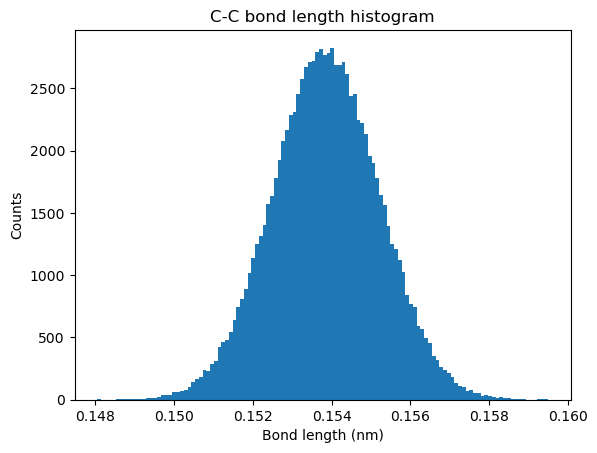

In [15]:
import matplotlib.pyplot as plt

bondcounts, binedges, otherstuff = plt.hist(bond_length, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

## Your Turn
A torsion is made up of four atoms which are bonded to each other. Analyze the torsion angle associated with the atoms `H11-C1-C2-H21` for your trajectory. Instead of using the function `compute_distance`, use `compute_dihedrals`. Create a histogram plot of the torsion angles.

First, we need to pick the atom indices of our torsion angle and use the `compute_dihedrals` function to calculate the dihedrals.

In [29]:
phi_indices = [[1,0,4,5]] # add atoms to define the torsion angle
phi = md.compute_dihedrals(traj,phi_indices)# use the compute_dihedrals function

print(phi)

[[ 1.3142321]
 [ 1.0576149]
 [ 0.7498143]
 ...
 [-0.6018369]
 [-0.7240137]
 [-1.1177353]]


We now have the measurement for this torsion angle in radians for each recorded timestep of the trajectory.

Next, we can examine this data by plotting it as a histogram using the Python library `matplotlib`.

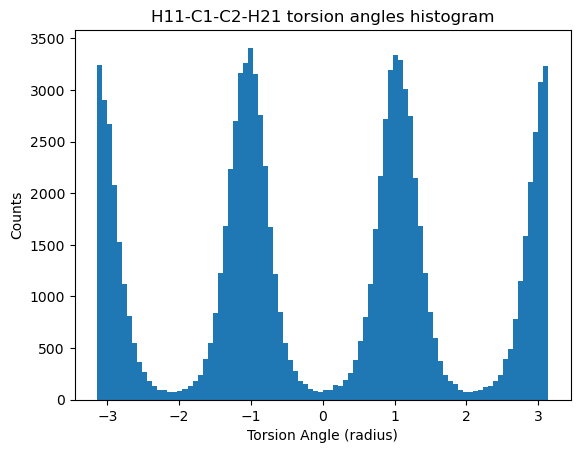

In [31]:
import matplotlib.pyplot as plt

bondcounts, binedges, otherstuff = plt.hist(phi, bins=90)
plt.title('H11-C1-C2-H21 torsion angles histogram')
plt.xlabel('Torsion Angle (radius)')
plt.ylabel('Counts')
plt.show()

# create a histogram with 90 bins

Credit for this exercise goes to [MolSSI](https://education.molssi.org/mm-tools/02-md-alkanes/index.html).

### Reflection:
The histogram shows that the H11 and H21 atoms are tend to have an angel of $\pi$/3 and $\pi$, which make sense.